### Libraries and Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split

In [2]:
#global variables
D=10 #how many lagged values to consider
min_date_train='2018-01-01'
max_date_train='2018-01-31'
min_date_predict='2018-02-01'
max_date_predict='2018-02-28'

### Loading data

In [3]:
header = ["date","time","flow","anomaly"]
df = pd.read_csv('barreiro_ano.csv', sep=';', names=header)
df

,date,time,flow,anomaly
0,01/01/2018,00:07:30,18.333067,0
1,01/01/2018,00:22:30,18.333067,0
2,01/01/2018,00:37:30,19.784872,0
3,01/01/2018,00:52:30,22.294744,0
4,01/01/2018,01:07:30,27.229756,0
...,...,...,...,...
35035,31/12/2018,22:52:30,24.792000,0
35036,31/12/2018,23:07:30,23.029933,0
35037,31/12/2018,23:22:30,20.415628,0
35038,31/12/2018,23:37:30,22.019056,0


In [4]:
#convert column to date time
df['date'] = pd.to_datetime(df['date'])


In [5]:
# to extract all unique values (time) present in dataframe
time_unique_val=df.time.unique()
time_unique_val

array(['00:07:30', '00:22:30', '00:37:30', '00:52:30', '01:07:30',
       '01:22:30', '01:37:30', '01:52:30', '02:07:30', '02:22:30',
       '02:37:30', '02:52:30', '03:07:30', '03:22:30', '03:37:30',
       '03:52:30', '04:07:30', '04:22:30', '04:37:30', '04:52:30',
       '05:07:30', '05:22:30', '05:37:30', '05:52:30', '06:07:30',
       '06:22:30', '06:37:30', '06:52:30', '07:07:30', '07:22:30',
       '07:37:30', '07:52:30', '08:07:30', '08:22:30', '08:37:30',
       '08:52:30', '09:07:30', '09:22:30', '09:37:30', '09:52:30',
       '10:07:30', '10:22:30', '10:37:30', '10:52:30', '11:07:30',
       '11:22:30', '11:37:30', '11:52:30', '12:07:30', '12:22:30',
       '12:37:30', '12:52:30', '13:07:30', '13:22:30', '13:37:30',
       '13:52:30', '14:07:30', '14:22:30', '14:37:30', '14:52:30',
       '15:07:30', '15:22:30', '15:37:30', '15:52:30', '16:07:30',
       '16:22:30', '16:37:30', '16:52:30', '17:07:30', '17:22:30',
       '17:37:30', '17:52:30', '18:07:30', '18:22:30', '18:37:

In [6]:
# in order to accept time series with different periods per day
periods_per_day=len(time_unique_val)
periods_per_day

96

In [7]:
time_unique_ind=np.arange(periods_per_day)
time_unique_ind

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [8]:
#in order to have a mapping between the time of day and its index
time_unique=pd.DataFrame({'time':time_unique_val, 'time_unique_ind':time_unique_ind})
time_unique

,time,time_unique_ind
0,00:07:30,0
1,00:22:30,1
2,00:37:30,2
3,00:52:30,3
4,01:07:30,4
...,...,...
91,22:52:30,91
92,23:07:30,92
93,23:22:30,93
94,23:37:30,94


In [9]:
#creates a column with the time index
df['time_ind'] = df['time'].map(time_unique.set_index('time')['time_unique_ind'])
df.head()

,date,time,flow,anomaly,time_ind
0,2018-01-01,00:07:30,18.333067,0,0
1,2018-01-01,00:22:30,18.333067,0,1
2,2018-01-01,00:37:30,19.784872,0,2
3,2018-01-01,00:52:30,22.294744,0,3
4,2018-01-01,01:07:30,27.229756,0,4


In [10]:
#extra column indicating day of week
#0: mon, 1:tue, ..., 5:sat, 6:sun
df['dayofweek'] = pd.to_datetime(df['date'],dayfirst=True)
df['dayofweek'] = df['dayofweek'].dt.dayofweek
df.head()

,date,time,flow,anomaly,time_ind,dayofweek
0,2018-01-01,00:07:30,18.333067,0,0,0
1,2018-01-01,00:22:30,18.333067,0,1,0
2,2018-01-01,00:37:30,19.784872,0,2,0
3,2018-01-01,00:52:30,22.294744,0,3,0
4,2018-01-01,01:07:30,27.229756,0,4,0


In [11]:
holidays = pd.read_csv('Holidays.csv',sep=';')
holidays['date'] = pd.to_datetime(holidays['date'])
holidays.head()

,date
0,1970-01-01
1,1970-03-27
2,1970-03-29
3,1970-05-28
4,1970-10-05


In [12]:
# if day is a holiday, then dayofweek is -1
df.loc[df.date.isin(holidays.date), 'dayofweek'] = -1

In [13]:
#check if it worked
df[df.date=='2018-12-25']

,date,time,flow,anomaly,time_ind,dayofweek
34368,2018-12-25,00:07:30,17.262144,0,0,-1
34369,2018-12-25,00:22:30,16.214972,0,1,-1
34370,2018-12-25,00:37:30,17.899456,0,2,-1
34371,2018-12-25,00:52:30,18.460372,0,3,-1
34372,2018-12-25,01:07:30,18.859117,0,4,-1
...,...,...,...,...,...,...
34459,2018-12-25,22:52:30,20.637778,0,91,-1
34460,2018-12-25,23:07:30,16.250867,0,92,-1
34461,2018-12-25,23:22:30,15.554350,0,93,-1
34462,2018-12-25,23:37:30,15.301328,0,94,-1


## Lags of time series

### D previous readings

In [14]:
# in order to construct a new dataframe with D lagged values
df_lagged = df.copy()
number_lags = D # this is D (a global variable - check top of notebook)

for i in range(1, number_lags+1):
    shifted = df['flow'].shift(i)
    df_lagged = pd.concat((df_lagged, shifted), axis=1)

In [15]:
# just to label the columns of the resulting dataframe
lagged_cols=["n-"+ str(x) for x in range(1,number_lags+1)]
colnames= ["date","time","flow","anomaly", "time_ind","dayofweek"]+lagged_cols
df_lagged.columns=colnames
df_lagged.head()

,date,time,flow,anomaly,time_ind,dayofweek,n-1,n-2,n-3,n-4,n-5,n-6,n-7,n-8,n-9,n-10
0,2018-01-01,00:07:30,18.333067,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,00:22:30,18.333067,0,1,-1,18.333067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,00:37:30,19.784872,0,2,-1,18.333067,18.333067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,00:52:30,22.294744,0,3,-1,19.784872,18.333067,18.333067,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,01:07:30,27.229756,0,4,-1,22.294744,19.784872,18.333067,18.333067,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# in order to drop the rows corresponding do the first day
#to get rid of the NaN values

df_lagged =  df_lagged.iloc[periods_per_day:]
df_lagged.head()

,date,time,flow,anomaly,time_ind,dayofweek,n-1,n-2,n-3,n-4,n-5,n-6,n-7,n-8,n-9,n-10
96,2018-02-01,00:07:30,15.008750,0,0,3,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994,21.542819,22.036933,23.194106
97,2018-02-01,00:22:30,13.375950,0,1,3,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994,21.542819,22.036933
98,2018-02-01,00:37:30,12.083542,0,2,3,13.375950,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994,21.542819
99,2018-02-01,00:52:30,12.161200,0,3,3,12.083542,13.375950,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994
100,2018-02-01,01:07:30,25.701713,0,4,3,12.161200,12.083542,13.375950,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067


In [17]:
#df_weekdays: contains data related to weekdays 
#df_sat: contains data related to saturdays
#df_sun: contains data related to sundays and holidays
df_weekdays = df_lagged[(df_lagged['dayofweek']>=0) & (df_lagged['dayofweek']<=4)]
df_sat = df_lagged[df_lagged['dayofweek']==5]
df_sun = df_lagged[(df_lagged['dayofweek']==-1) | (df_lagged['dayofweek']==6)]

In [18]:
#get data to train a particular period (first of the day, eg)
'''
to create a dataframe that can be used to train a model
we should choose a range of dates (min_date, max_date)
a typeofdate ('weekdays', 'saturdays', 'sundays' (this one includes holidays))
and a period of the day (time_ind that can range from 0 to periods_per_day)
'''
def create_data_for_model(min_date, max_date, typeofday, time_ind):
    if typeofday=='weekdays':
        sel_data=df_weekdays[(df_weekdays.date>=min_date) & (df_weekdays.date<=max_date)]
    elif typeofday=='saturdays':
        sel_data=df_sat[(df_sat.date>=min_date) & (df_sat.date<=max_date)]
    else:
        sel_data=df_sun[(df_sun.date>=min_date) & (df_sun.date<=max_date)]
    sel_data=sel_data[sel_data['time_ind']==time_ind]
    return sel_data
 

In [19]:
#an example, just to test
data=create_data_for_model('2018-01-01', '2018-01-30', 'weekdays', 0)
#data

In [21]:
"""
data: dataframe containing data for a specific type of day and 
for a specific time_ind
"""
def svr_model(data):
    y=data['flow'].copy()
    X=data.iloc[:,6:] #contains only the D previous values
    # 70% train, 30% test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
    svr_model = svm.SVR(C=10.0, epsilon=0.5)
    svr_model.fit(X_train, y_train)
    return svr_model

In [22]:
#just for testing
#svr_model(data)

In [23]:
# creates a model for each period for weekdays
# for  a min_date-max_date range
# the result is a dataframe with as many rows as periods_per_day
# each containing a regressor
def creates_regressors_weekdays(min_date, max_date):
    regressors_weekdays = []
    
    for i in range(periods_per_day):
        data=create_data_for_model(min_date, max_date, 'weekdays', i)
        regressors_weekdays.append(svr_model(data))
    return regressors_weekdays


In [24]:
# creates a model for each period for saturdays
# for  a min_date-max_date range
# the result is a dataframe with as many rows as periods_per_day
# each containing a regressor
def creates_regressors_saturdays(min_date, max_date):
    regressors_saturdays = []
    
    for i in range(periods_per_day):
        data=create_data_for_model(min_date, max_date, 'weekdays', i)
        regressors_saturdays.append(svr_model(data))
    return regressors_saturdays



In [25]:
# creates a model for each period for sundays and holidays
# for  a min_date-max_date range
# the result is a dataframe with as many rows as periods_per_day
# each containing a regressor
def creates_regressors_sundays(min_date, max_date):
    regressors_sundays = []
    
    for i in range(periods_per_day):
        data=create_data_for_model(min_date, max_date, 'weekdays', i)
        regressors_sundays.append(svr_model(data))
    return regressors_sundays

In [26]:
def predict_flow(df):
    predictions=[]
    for i in range(len(df)):
        if ((df.iloc[i,5]>=0) and (df.iloc[i,5] <=4)):
            model=regressors_weekdays[df.iloc[i,4]]
            predictions.append(model.predict(df.iloc[i:i+1,6:]))
        elif (df.iloc[i,5]==5): # i.e. saturdays
            model=regressors_saturdays[df.iloc[i,4]]
            predictions.append(model.predict(df.iloc[i:i+1,6:]))
        else: #i.e., sundays and holidays
            model=regressors_sundays[df.iloc[i,4]]
            predictions.append(model.predict(df.iloc[i:i+1,6:]))
      
    return predictions

            

In [27]:
# for testing, we will use 2018-01-01 to 2018-01-31 for
# constructing regressors
regressors_weekdays=creates_regressors_weekdays(min_date_train, max_date_train)
regressors_saturdays=creates_regressors_saturdays(min_date_train, max_date_train)
regressors_sundays=creates_regressors_weekdays(min_date_train, max_date_train)

In [28]:
df2predict=df_lagged[(df_lagged.date>=min_date_predict) & (df_lagged.date<=max_date_predict)]

In [29]:

predictions=predict_flow(df2predict)


In [30]:
real=df2predict['flow']
real_1d=real[0:periods_per_day] # to look at 1 day


In [31]:
predictions_1d=predictions[0:periods_per_day]

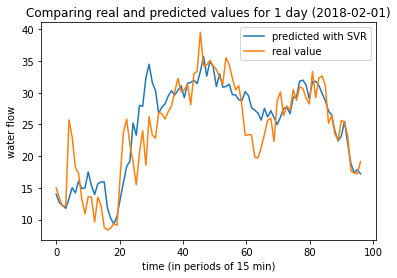

In [32]:
x = np.linspace(0,len(predictions_1d),len(predictions_1d)) 
plt.plot(x,predictions_1d,label='predicted with SVR')
plt.plot(x,real_1d, label='real value')
plt.xlabel('time (in periods of 15 min)')
plt.ylabel('water flow')
plt.title("Comparing real and predicted values for 1 day (2018-02-01)")
plt.legend()
plt.show()

In [33]:
real_7d=real[0:periods_per_day*7] # to look at 7 day
predictions_7d=predictions[0:periods_per_day*7]

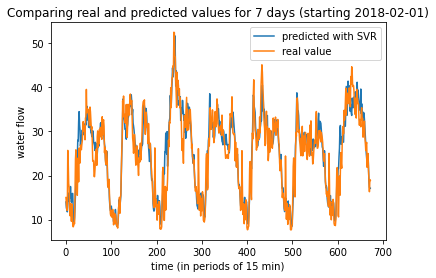

In [34]:
x = np.linspace(0,len(predictions_7d),len(predictions_7d)) 
plt.plot(x,predictions_7d,label='predicted with SVR')
plt.plot(x,real_7d, label='real value')
plt.xlabel('time (in periods of 15 min)')
plt.ylabel('water flow')
plt.title("Comparing real and predicted values for 7 days (starting 2018-02-01)")
plt.legend()
plt.show()